In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


from tqdm import tqdm

In [2]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / total
    return avg_train_loss, train_accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)
            y_true += labels.tolist()
            y_pred += preds.tolist()
            
    loss = running_loss / total_samples
    accuracy = running_corrects / total_samples
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    return loss, accuracy, f1, cm



In [3]:
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)

class ModifiedSqueezeNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedSqueezeNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            Fire(3, 24, 48, 48),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Fire(96, 48, 96, 96),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Fire(192, 64, 128, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Fire(256, 64, 256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Fire(512, 64, 128, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Fire(256, 48, 96, 96),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Fire(192, 24, 48, 48)
        )        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(96, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# Load the data from files
X = np.load('aug_img.npy')
y = np.load('aug_lbl.npy')

# Split the data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_train, random_state=42)


In [21]:
y_val_test.shape

(195,)

In [44]:
# Load the data from files
X = np.load('aug_img.npy')
y = np.load('aug_lbl.npy')

# Split the data into train, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, stratify=y_val_test, random_state=42)

# Create TensorDataset objects for train, validation, and test sets
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test))

# Create DataLoader objects for train, validation, and test sets
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [45]:
torch.manual_seed(42)

device = 'mps'

model = ModifiedSqueezeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_loss = float('inf')
patience = 3
threshold = 0.4
counter = 0

tr_loss_hist, tr_acc_hist = [], []
val_loss_hist, val_acc_hist = [], []

for epoch in range(32):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, f1, cm = evaluate(model, val_loader, criterion, device)

    tr_loss_hist.append(train_loss)
    tr_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    
    print(f'Epoch {epoch+1}: TrLoss: {train_loss:.4f}, TrAcc: {train_acc:.4f} - ValLoss: {val_loss:.4f}, ValAcc: {val_acc:.4f}')

    # early stopping
    if val_loss < best_loss and val_loss > threshold:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
            break
        if  val_loss <= threshold:
            print(f'Validation loss crossed defined threshold {threshold}. Early stopping...')
            break

test_loss, test_acc, test_f1, test_cm = evaluate(model, test_loader, criterion, device)

100%|██████████| 104/104 [00:21<00:00,  4.76it/s]


Epoch 1: TrLoss: 0.6946, TrAcc: 0.5000 - ValLoss: 0.6946, ValAcc: 0.4932


100%|██████████| 104/104 [00:20<00:00,  5.17it/s]


Epoch 2: TrLoss: 0.6943, TrAcc: 0.5000 - ValLoss: 0.6942, ValAcc: 0.4932


100%|██████████| 104/104 [00:19<00:00,  5.23it/s]


Epoch 3: TrLoss: 0.6939, TrAcc: 0.5000 - ValLoss: 0.6936, ValAcc: 0.4932


100%|██████████| 104/104 [00:20<00:00,  5.18it/s]


Epoch 4: TrLoss: 0.6594, TrAcc: 0.6005 - ValLoss: 0.5799, ValAcc: 0.6712


100%|██████████| 104/104 [00:20<00:00,  5.08it/s]


Epoch 5: TrLoss: 0.5498, TrAcc: 0.7458 - ValLoss: 0.4703, ValAcc: 0.8356


100%|██████████| 104/104 [00:20<00:00,  5.08it/s]


Epoch 6: TrLoss: 0.3814, TrAcc: 0.8511 - ValLoss: 0.3190, ValAcc: 0.8767
Validation loss crossed defined threshold 0.4. Early stopping...


Test Loss: 0.3230, Test Accuracy: 0.8904 - f1_score: 0.8750


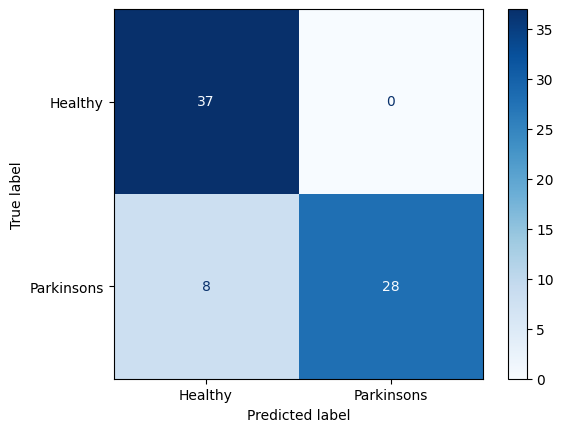

In [52]:
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} - f1_score: {test_f1:.4f}')
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Healthy','Parkinsons'])

disp.plot(cmap="Blues");

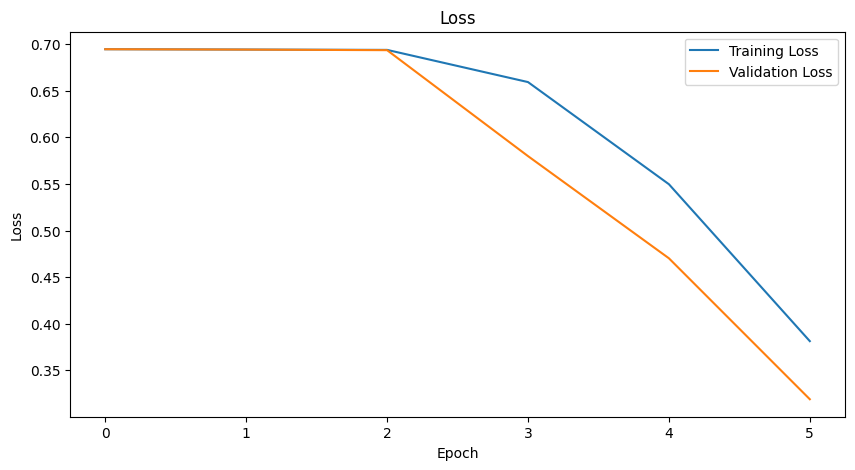

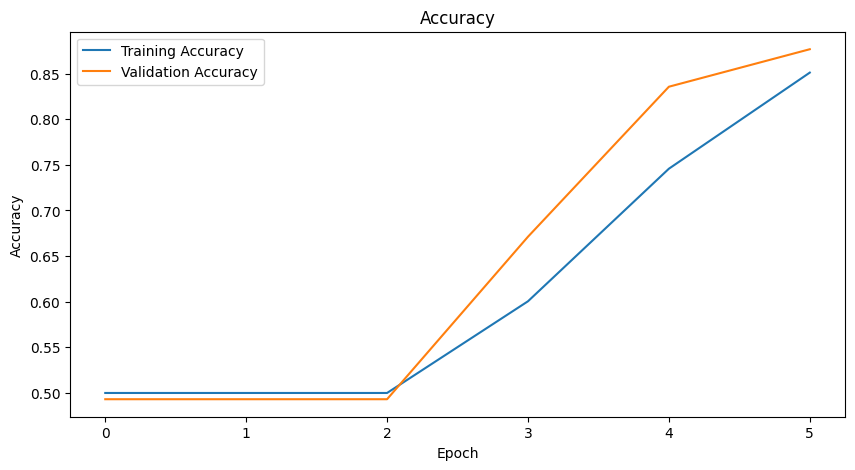

In [53]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(tr_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(tr_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
